## Train experiments with an autoencoder as DR

 $L_{total} = \lambda_1 * L_{reconstruction} + \lambda_2 * L_{swapping-difference}$

Train an autoencoder with swapping loss

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt

# local imports
from setup import setup_device, setup_datamodule, load_model
from dimensionality_reduction.feature_autoencoder import FeatureAutoencoder



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:2')
print(device, type(device))

cuda:2 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

### Preparation

Take the first batch from the datamodule

In [6]:
data_batch = next(iter(datamodule.val_dataloader()))

data_sample = data_batch['input']
data_sample.size() # [batch size, channels, width, hegiht]

torch.Size([32, 1, 256, 256])

In [7]:
selected_layer_names = [
  'model.model.1.submodule.0.conv.unit0.adn.A',
  'model.model.1.submodule.0.conv.unit1.adn.A',
  # 'model.model.1.submodule.0.conv.unit2.adn.A',
  'model.model.1.submodule.0.conv.unit3.adn.A',
  # 'model.model.1.submodule.1.submodule.2.1.conv'
  ]

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

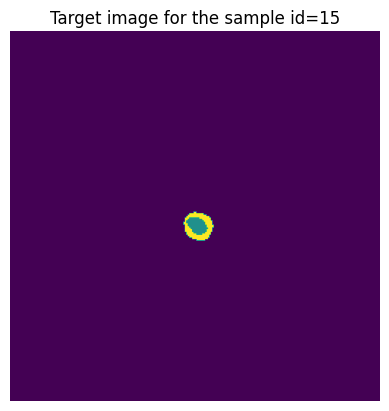

In [8]:
SAMPLE_ID = 15

data_sample_target = data_batch['target'][SAMPLE_ID]
print(data_sample_target.size())

plt.imshow(data_sample_target.detach().numpy().transpose(1, 2, 0))
plt.title(f'Target image for the sample id={SAMPLE_ID}')
plt.axis("off")

## Whole Dataset Training

In [9]:
# FILE_NAME = 'modified_encoder_e15_balanced'
from datetime import datetime

now = datetime.now()
FILE_NAME = 'encoder_' + now.strftime("%H-%M_%d-%m-%Y")

In [11]:
# model train params
EPOCHS_COUNT = 20
LEARNING_RATE = 1e-3
WEIGHT_I = 1 # image loss weight
WEIGHT_M = .2 # model loss weight

OUT_DIMS = 3 # output dims of dim reduction
C = 32 # input channels
BATCH_SIZE = datamodule.batch_size


In [12]:
# progressive training implementation
start_epoch = 0
start_weight = .1
added_weight = .4

def get_weight_m(current_epoch):
    if current_epoch > start_epoch:
        progress = (current_epoch - start_epoch) / (EPOCHS_COUNT - start_epoch)
        current_model_weight = start_weight + (added_weight * progress)  # start → sum(start+add)
        
        return current_model_weight
    
    return 0

### Train new autoencoder

In [14]:
from dimensionality_reduction.train import modified_train_dr

In [15]:
autoencoder = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [16]:
import wandb

# Initialize wandb
wandb.init(project="modified-autoencoder-training", name=FILE_NAME,
           config={
            "learning_rate": LEARNING_RATE, "epochs": EPOCHS_COUNT,
            "batch_size": BATCH_SIZE, "image_loss_weight": WEIGHT_I,
            "model_loss_weight": WEIGHT_M,
            "progressive_model_weight": True,
           })

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vaklr (vaklr-bonn). Use `wandb login --relogin` to force relogin


In [17]:
# Track model parameters
wandb.watch(autoencoder, log="all", log_freq=10)

In [20]:
modified_train_dr(autoencoder=autoencoder, datamodule=datamodule,
                                model=model, device=device,
                                logger=wandb.log,
                                selected_layer_names=selected_layer_names,
                                num_epochs=EPOCHS_COUNT, learning_rate=LEARNING_RATE,
                                weight_i=WEIGHT_I, weight_m=WEIGHT_M,
                                get_weight_m=get_weight_m)

KeyboardInterrupt: 

In [18]:
# Finish wandb run
wandb.finish()

### Display results

In [19]:
from visualization_utils.layer_visualizer import LayerVisualizer

layer_visualizer = LayerVisualizer()

In [20]:
from adapters.main import capture_convolution_layers

wrapper, layer_names = capture_convolution_layers(model, device, data_sample)
layer_samples = wrapper.layer_activations[selected_layer_names[2]]

In [21]:
selected_sample = layer_samples[SAMPLE_ID]
original_np = selected_sample.detach().numpy()

In [22]:
latent, reconstructed = autoencoder(selected_sample)
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

In [23]:
latent_np.shape

(3, 64, 64)

/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1291 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


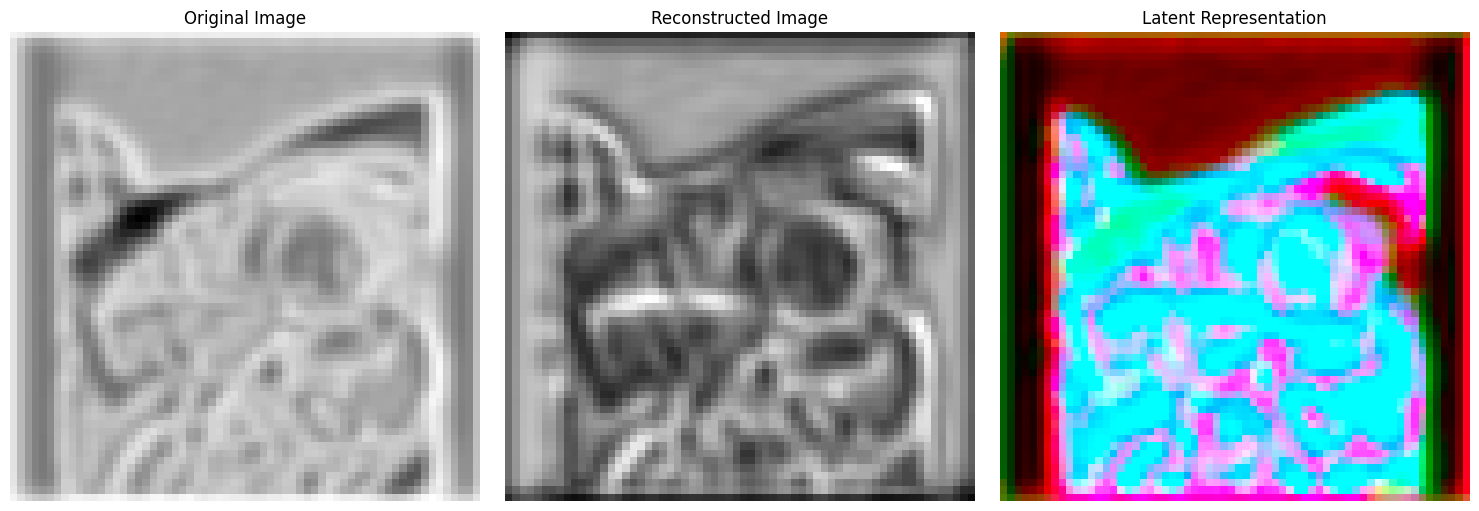

In [24]:
layer_visualizer.plot(original_np, reconstructed_np, latent_np)

In [25]:
import torch

def print_image_error(original, reconstruction):
    criterion = torch.nn.MSELoss()
    mse_error = criterion(original, reconstruction).item()

    print(f"MSE Error: {mse_error}")

In [26]:
print_image_error(selected_sample, reconstructed)

MSE Error: 0.3359999656677246


Let's examine MSEs of some samples from different layers...

1. one of the trained layers:

/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 567 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


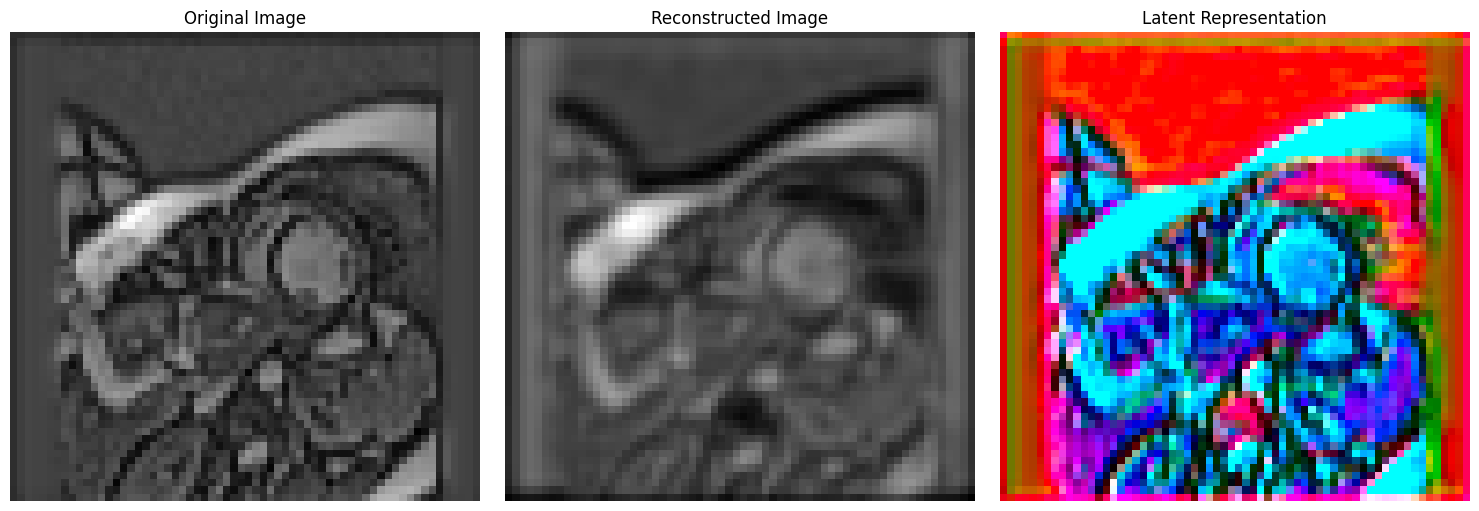

MSE Error: 0.4789718687534332


In [27]:
layer_samples_new = wrapper.layer_activations['model.model.1.submodule.0.conv.unit0.adn.A']
selected_sample_new = layer_samples_new[15]
latent_new, reconstructed_new = autoencoder(selected_sample_new)

original_np_new = selected_sample_new.detach().numpy()
latent_np_new = latent_new.detach().numpy()
reconstructed_np_new = reconstructed_new.detach().numpy()
layer_visualizer.plot(original_np_new, reconstructed_np_new, latent_np_new)
print_image_error(selected_sample_new, reconstructed_new)

2. from the one we haven't trained on:

/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 74 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


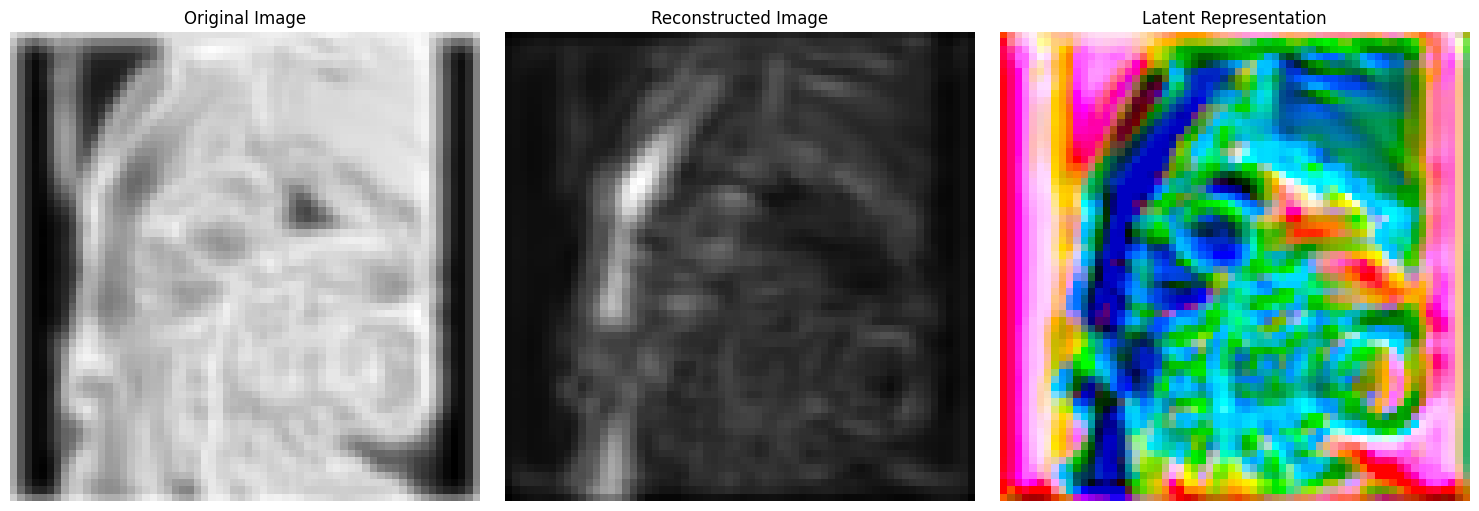

MSE Error: 1.0079575777053833


In [28]:
layer_samples_new = wrapper.layer_activations['model.model.1.submodule.0.conv.unit2.adn.A']
selected_sample_new = layer_samples_new[30]
original_np_new = selected_sample_new.detach().numpy()
latent_new, reconstructed_new = autoencoder(selected_sample_new)
latent_np_new = latent_new.detach().numpy()
reconstructed_np_new = reconstructed_new.detach().numpy()
layer_visualizer.plot(original_np_new, reconstructed_np_new, latent_np_new)
print_image_error(selected_sample_new, reconstructed_new)

### Save trained autoencoder

In [30]:
from model_saver import ModelSaver

saver = ModelSaver('./modified_autoencoders')

saver.save_model_config(autoencoder, file_name=FILE_NAME)

Model saved to ./modified_autoencoders/encoder_20-43_02-03-2025.pth


### Load saved autoencoder

In [38]:
# Initialize the same autoencoder structure
autoencoder_saved = FeatureAutoencoder(C, OUT_DIMS)
saver.load_autoencoder_config(autoencoder_saved, FILE_NAME)

defined an autoencoder with input channels=16 and out channels=3
Autoencoder loaded successfully


/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../dimensionality_reduction/save_utils.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_s